# Linear models with CNN features

In [100]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

## Introduction

We need to find a way to convert the imagenet predictions to a probability of being a cat or a dog, since that is what the Kaggle competition requires us to submit. We could use the imagenet hierarchy to download a list of all the imagenet categories in each of the dog and cat groups, and could then solve our problem in various ways, such as:

- Finding the largest probability that's either a cat or a dog, and using that label
- Averaging the probability of all the cat categories and comparing it to the average of all the dog categories.

But these approaches have some downsides:

- They require manual coding for something that we should be able to learn from the data
- They ignore information available in the predictions; for instance, if the models predicts that there is a bone in the image, it's more likely to be a dog than a cat.

A very simple solution to both of these problems is to learn a linear model that is trained using the 1,000 predictions from the imagenet model for each image as input, and the dog/cat label as target.

In [101]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [102]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Linear models in keras

It turns out that each of the Dense() layers is just a *linear model*, followed by a simple *activation function*. We'll learn about the activation function later - first, let's review how linear models work.

A linear model is (as I'm sure you know) simply a model where each row is calculated as *sum(row &#42; weights)*, where *weights* needs to be learnt from the data, and will be the same for every row. For example, let's create some data that we know is linearly related:

In [4]:
x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

In [5]:
x[:5]

array([[ 0.2435,  0.2841],
       [ 0.9906,  0.5377],
       [ 0.766 ,  0.2083],
       [ 0.9321,  0.4173],
       [ 0.6888,  0.2141]])

In [6]:
y[:5]

array([ 2.3392,  4.5943,  3.1568,  4.116 ,  3.02  ])

We can use keras to create a simple linear model (*Dense()* - with no activation - in Keras) and optimize it using SGD to minimize mean squared error (*mse*):

In [7]:
"""
lm_eugene = Sequential() # define model
lm_eugene.add(Dense(output_dim=1, input_shape=(2,), activation='linear')) # first layer, define input shape; last year, define output shape
lm_eugene.compile(optimizer=SGD(lr=0.1), loss='mse') # define optimizer, relatively high learning rate

print(lm_eugene.evaluate(x, y)) # untrained MSE
lm_eugene.fit(x, y, batch_size=1, nb_epoch=10) # define mini_batch, # epochs
print(lm_eugene.evaluate(x, y)) # trained MSE

print(((np.array(y).reshape((-1, 1)) - lm_eugene.predict(x)) ** 2).mean()) # MSE
print(lm_eugene.predict([x[0:2]])) # predictions
print(lm_eugene.get_weights()) # get the coefficientsS
""";

In [8]:
lm = Sequential([ Dense(1, input_shape=(2,)) ])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

(See the *Optim Tutorial* notebook and associated Excel spreadsheet to learn all about SGD and related optimization algorithms.)

This has now learnt internal weights inside the lm model, which we can use to evaluate the loss function (MSE).

In [9]:
lm.evaluate(x, y, verbose=0)

13.907087326049805

In [10]:
lm.fit(x, y, nb_epoch=10, batch_size=1) # are weights already initialized? where's the glorot?

Epoch 1/10
30/30 [==============================] - 0s - loss: 1.4235     
Epoch 2/10
30/30 [==============================] - 0s - loss: 0.1368     
Epoch 3/10
30/30 [==============================] - 0s - loss: 0.0551     
Epoch 4/10
30/30 [==============================] - 0s - loss: 0.0192     
Epoch 5/10
30/30 [==============================] - 0s - loss: 0.0077     
Epoch 6/10
30/30 [==============================] - 0s - loss: 0.0027     
Epoch 7/10
30/30 [==============================] - 0s - loss: 9.4300e-04     
Epoch 8/10
30/30 [==============================] - 0s - loss: 3.3122e-04     
Epoch 9/10
30/30 [==============================] - 0s - loss: 1.5470e-04     
Epoch 10/10
30/30 [==============================] - 0s - loss: 5.8645e-05     


In [11]:
lm.evaluate(x, y, verbose=0)

3.1372303055832162e-05

And, of course, we can also take a look at the weights - after fitting, we should see that they are close to the weights we used to calculate y (2.0, 3.0, and 1.0).

In [12]:
lm.get_weights() # does it get weights for 1 layer?

[array([[ 1.9939],
        [ 2.984 ]], dtype=float32), array([ 1.0116], dtype=float32)]

## Train linear model on predictions

Using a Dense() layer in this way, we can easily convert the 1,000 predictions given by our model into a probability of dog vs cat--simply train a linear model to take the 1,000 predictions as input, and return dog or cat as output, learning from the Kaggle data. This should be easier and more accurate than manually creating a map from imagenet categories to one dog/cat category. 

### Training the model

We start with some basic config steps. We copy a small amount of our data into a 'sample' directory, with the exact same structure as our 'train' directory--this is *always* a good idea in *all* machine learning, since we should do all of our initial testing using a dataset small enough that we never have to wait for it.

In [13]:
#path = "data/dogscats/sample/"
path = "data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

We will process as many images at a time as our graphics card allows. This is a case of trial and error to find the max batch size - the largest size that doesn't give an out of memory error.

In [14]:
batch_size=100
#batch_size=4

We need to start with our VGG 16 model, since we'll be using its predictions and features.

In [15]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Our overall approach here will be:

1. Get the true labels for every image
2. Get the 1,000 imagenet category predictions for every image
3. Feed these predictions as input to a simple linear model.

Let's start by grabbing training and validation batches.

In [16]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path + 'valid', shuffle=False, batch_size=1)
batches = get_batches(path + 'train', shuffle=False, batch_size=1)

Found 5000 images belonging to 2 classes.
Found 12800 images belonging to 2 classes.


Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [17]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

We have provided a simple function that joins the arrays from all the batches - let's use this to grab the training and validation data:

In [18]:
"""
%%time
trn_data = get_data(path+'train')
val_data = get_data(path+'valid')
""";

In [19]:
"""
%%time
save_array(model_path + 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)
""";

We can load our training and validation data later without recalculating them:

In [20]:
%%time
trn_data = load_array(model_path + 'train_data.bc')
val_data = load_array(model_path + 'valid_data.bc')

CPU times: user 10.9 s, sys: 9.19 s, total: 20 s
Wall time: 8.18 s


Keras returns *classes* as a single column, so we convert to one hot encoding

In [123]:
get_data??

In [120]:
trn_data.shape

(12800, 3, 224, 224)

In [126]:
trn_features.shape

(12800, 1000)

In [129]:
trn_features[0]

array([  3.4163e-06,   1.2731e-06,   1.8867e-04,   6.4957e-05,   2.0718e-04,   1.4219e-04,
         1.3614e-04,   1.2631e-04,   7.9046e-04,   1.1801e-05,   2.4559e-07,   1.6843e-07,
         1.4293e-07,   6.7548e-06,   1.9814e-07,   1.2618e-05,   9.3915e-06,   7.8561e-05,
         1.3855e-05,   3.3227e-06,   1.4072e-05,   8.2577e-07,   2.8141e-06,   1.1918e-05,
         1.4971e-05,   1.0590e-06,   9.0508e-07,   4.1110e-07,   2.4905e-06,   1.2634e-05,
         7.3223e-07,   1.9947e-06,   9.3036e-07,   1.6476e-06,   3.6313e-05,   2.1088e-06,
         5.3324e-06,   1.8456e-06,   2.4794e-06,   5.1712e-06,   2.1963e-06,   3.5611e-07,
         4.2282e-07,   1.9414e-06,   1.1604e-06,   1.2245e-06,   2.7520e-06,   1.8639e-06,
         4.3741e-07,   1.8747e-05,   7.6698e-06,   1.1065e-03,   5.7624e-07,   8.1251e-07,
         6.3981e-06,   6.1959e-07,   3.3233e-06,   9.5924e-07,   1.9507e-06,   4.6529e-07,
         3.3667e-06,   1.2901e-06,   4.5760e-06,   3.0839e-07,   9.7048e-07,   1.0664e-06,

In [103]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

In [22]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [23]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [24]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

...and their 1,000 imagenet probabilties from VGG16--these will be the *features* for our linear model:

In [25]:
"""
%%time
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)
""";

In [26]:
"""trn_features.shape""";

In [27]:
"""
save_array(model_path + 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)
""";

We can load our training and validation features later without recalculating them:

In [28]:
trn_features = load_array(model_path + 'train_lastlayer_features.bc')
val_features = load_array(model_path + 'valid_lastlayer_features.bc')

Now we can define our linear model, just like we did earlier:

In [29]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

We're ready to fit the model!

In [30]:
batch_size = 64
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 12800 samples, validate on 5000 samples
Epoch 1/3
12800/12800 [==============================] - 0s - loss: 0.3098 - acc: 0.9592 - val_loss: 0.1445 - val_acc: 0.9680
Epoch 2/3
12800/12800 [==============================] - 0s - loss: 0.1107 - acc: 0.9664 - val_loss: 0.0909 - val_acc: 0.9704
Epoch 3/3
12800/12800 [==============================] - 0s - loss: 0.0851 - acc: 0.9693 - val_loss: 0.0814 - val_acc: 0.9714


In [31]:
lm.optimizer.lr = 0.5

In [32]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 12800 samples, validate on 5000 samples
Epoch 1/3
12800/12800 [==============================] - 0s - loss: 0.0786 - acc: 0.9704 - val_loss: 0.0790 - val_acc: 0.9722
Epoch 2/3
12800/12800 [==============================] - 0s - loss: 0.0752 - acc: 0.9714 - val_loss: 0.0786 - val_acc: 0.9724
Epoch 3/3
12800/12800 [==============================] - 0s - loss: 0.0735 - acc: 0.9730 - val_loss: 0.0780 - val_acc: 0.9736


### Viewing model prediction examples

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [33]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

4736/5000 [===========================>..] - ETA: 0s

array([ 1.    ,  1.    ,  0.9941,  1.    ,  1.    ,  0.999 ,  1.    ,  0.9999], dtype=float32)

In [34]:
preds[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

Get the filenames for the validation set, so we can view images:

In [35]:
filenames = val_batches.filenames

In [36]:
# Number of images to view for each visualization task
n_view = 4

Helper function to plot images by index in the validation set:

In [37]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

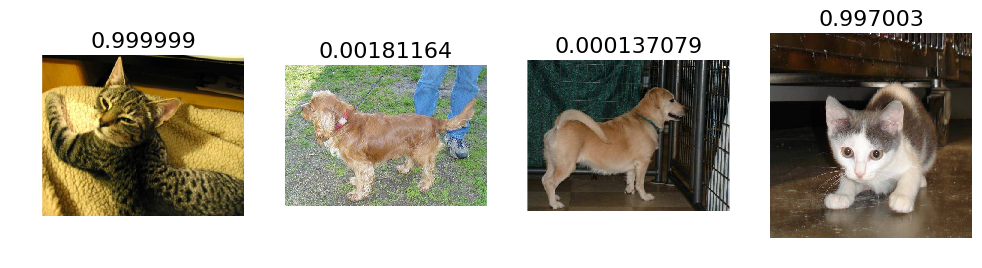

In [38]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

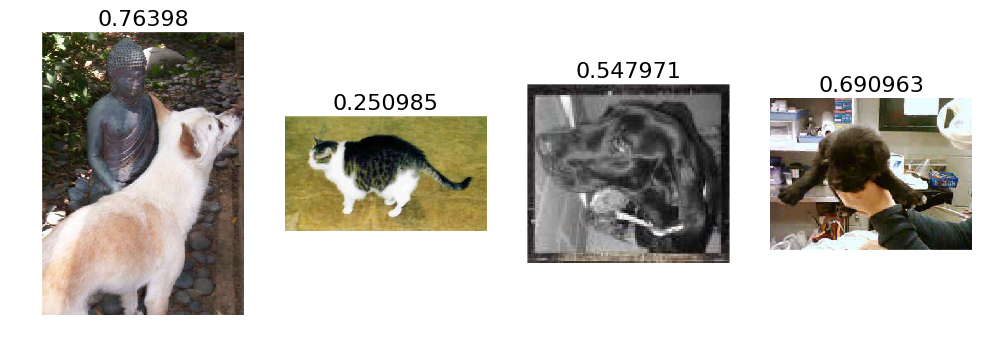

In [39]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

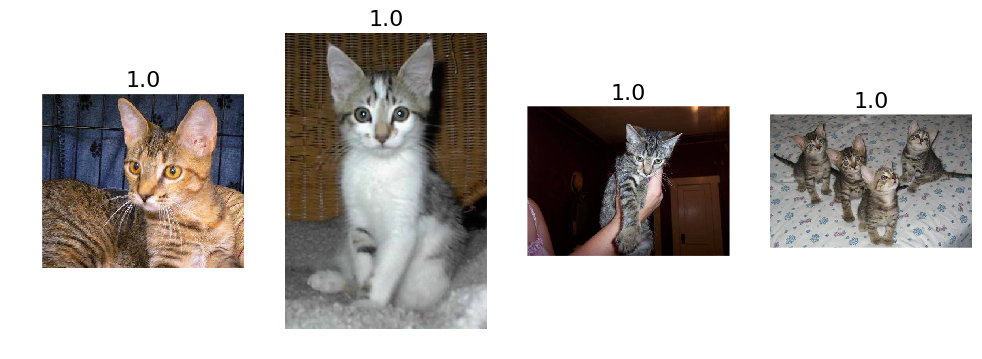

In [40]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

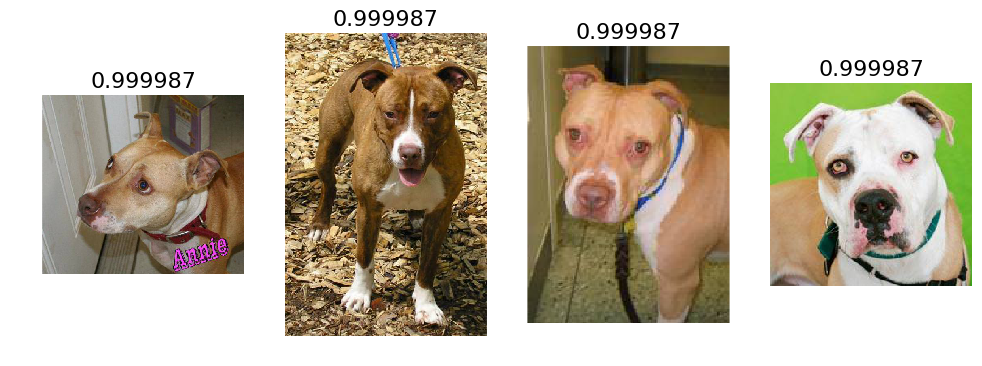

In [41]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

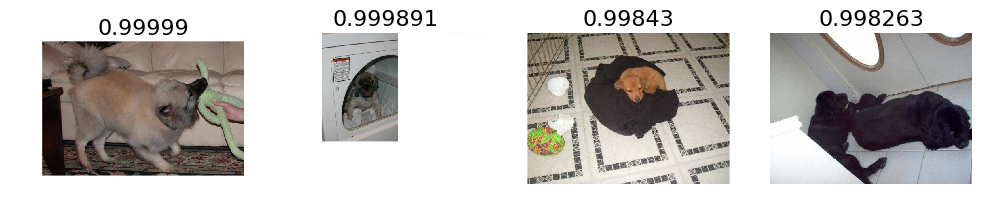

In [42]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

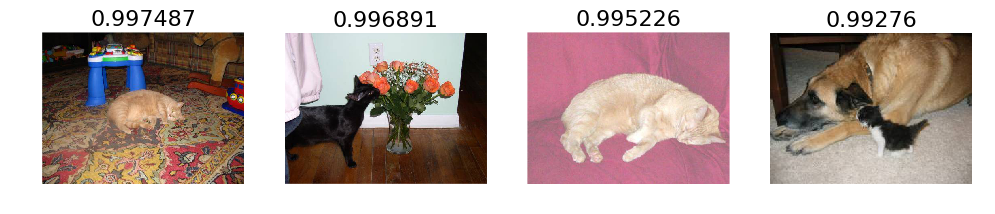

In [43]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], 1-probs[incorrect_dogs][most_incorrect_dogs])

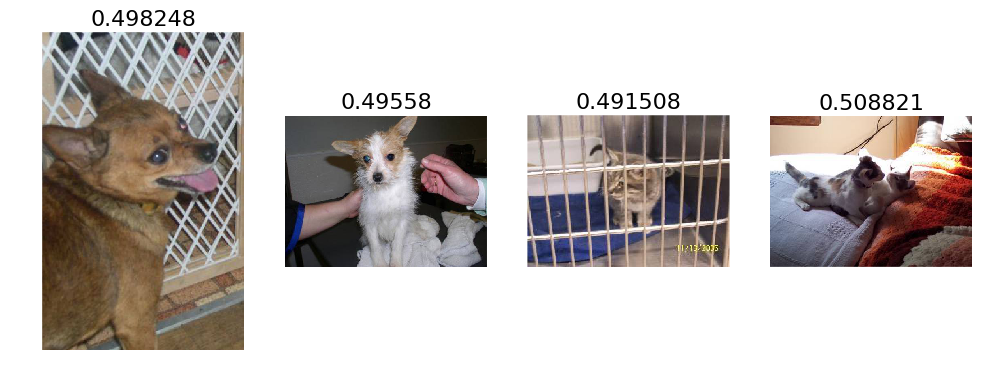

In [44]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [45]:
cm = confusion_matrix(val_classes, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[2424   76]
 [  56 2444]]


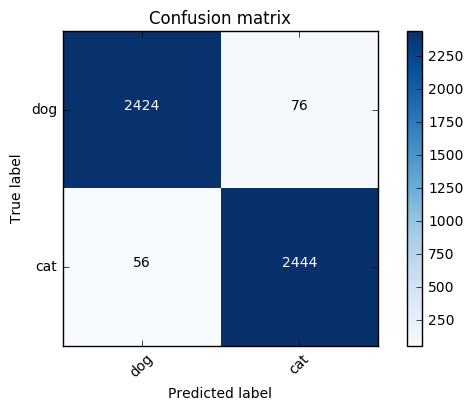

In [46]:
plot_confusion_matrix(cm, val_batches.class_indices)

### About activation functions

Do you remember how we defined our linear model? Here it is again for reference:

```python
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
```

And do you remember the definition of a fully connected layer in the original VGG?:

```python
model.add(Dense(4096, activation='relu'))
```

You might we wondering, what's going on with that *activation* parameter? Adding an 'activation' parameter to a layer in Keras causes an additional function to be called after the layer is calculated. You'll recall that we had no such parameter in our most basic linear model at the start of this lesson - that's because a simple linear model has no *activation function*. But nearly all deep model layers have an activation function - specifically, a *non-linear* activation function, such as tanh, sigmoid (```1/(1+exp(x))```), or relu (```max(0,x)```, called the *rectified linear* function). Why?

The reason for this is that if you stack purely linear layers on top of each other, then you just end up with a linear layer! For instance, if your first layer was ```2*x```, and your second was ```-2*x```, then the combination is: ```-2*(2*x) = -4*x```. If that's all we were able to do with deep learning, it wouldn't be very deep! But what if we added a relu activation after our first layer? Then the combination would be: ```-2 * max(0, 2*x)```. As you can see, that does not simplify to just a linear function like the previous example--and indeed we can stack as many of these on top of each other as we wish, to create arbitrarily complex functions.

And why would we want to do that? Because it turns out that such a stack of linear functions and non-linear activations can approximate any other function just as close as we want. So we can **use it to model anything**! This extraordinary insight is known as the *universal approximation theorem*. For a visual understanding of how and why this works, I strongly recommend you read Michael Nielsen's [excellent interactive visual tutorial](http://neuralnetworksanddeeplearning.com/chap4.html).

The last layer generally needs a different activation function to the other layers--because we want to encourage the last layer's output to be of an appropriate form for our particular problem. For instance, if our output is a one hot encoded categorical variable, we want our final layer's activations to add to one (so they can be treated as probabilities) and to have generally a single activation much higher than the rest (since with one hot encoding we have just a single 'one', and all other target outputs are zero). Our classication problems will always have this form, so we will introduce the activation function that has these properties: the *softmax* function. Softmax is defined as (for the i'th output activation): ```exp(x[i]) / sum(exp(x))```.

I suggest you try playing with that function in a spreadsheet to get a sense of how it behaves.

We will see other activation functions later in this course - but relu (and minor variations) for intermediate layers and softmax for output layers will be by far the most common.

# Modifying the model

## Retrain last layer's linear model

Since the original VGG16 network's last layer is Dense (i.e. a linear model) it seems a little odd that we are adding an additional linear model on top of it. This is especially true since the last layer had a softmax activation, which is an odd choice for an intermediate layer--and by adding an extra layer on top of it, we have made it an intermediate layer. What if we just removed the original final layer and replaced it with one that we train for the purpose of distinguishing cats and dogs? It turns out that this is a good idea - as we'll see!

We start by removing the last layer, and telling Keras that we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [47]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [48]:
model.pop()
for layer in model.layers: layer.trainable=False

**Careful!** Now that we've modified the definition of *model*, be careful not to rerun any code in the previous sections, without first recreating the model from scratch! (Yes, I made that mistake myself, which is why I'm warning you about it now...)

Now we're ready to add our new final layer...

In [49]:
model.add(Dense(2, activation='softmax'))

In [50]:
??vgg.finetune

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also *shuffle* the training batches, to add more randomness when using multiple epochs):

In [51]:
gen = image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True) # shuffling our training
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

We'll define a simple function for fitting models, just to save a little typing...

In [52]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

...and now we can use it to train the last layer of our model!

(It runs quite slowly, since it still has to calculate all the previous layers in order to know what input to pass to the new final layer. We could precalculate the output of the penultimate layer, like we did for the final layer earlier - but since we're only likely to want one or two iterations, it's easier to follow this alternative approach.)

In [53]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) # prints out loss and accuracy

In [54]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
12800/12800 [==============================] - 449s - loss: 0.8060 - acc: 0.9465 - val_loss: 0.3406 - val_acc: 0.9778
Epoch 2/2
12800/12800 [==============================] - 449s - loss: 0.5606 - acc: 0.9645 - val_loss: 0.6540 - val_acc: 0.9588


Before moving on, go back and look at how little code we had to write in this section to finetune the model. Because this is such an important and common operation, keras is set up to make it as easy as possible. We didn't even have to use any external helper functions in this section.

It's a good idea to save weights of all your models, so you can re-use them later. Be sure to note the git log number of your model when keeping a research journal of your results.

In [55]:
model.save_weights(model_path + 'finetune1.h5')

In [56]:
model.load_weights(model_path + 'finetune1.h5')

In [57]:
model.evaluate(val_data, val_labels)

5000/5000 [==============================] - 129s   


[0.653963545417792, 0.95879999999999999]

In [58]:
"""model.optimizer.lr = 0.01
fit_model(model, batches, val_batches, nb_epoch=1)
""";

In [59]:
model.metrics_names

['loss', 'acc']

We can look at the earlier prediction examples visualizations by redefining *probs* and *preds* and re-using our earlier code.

In [60]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:, 0]
probs[:8]

5000/5000 [==============================] - 127s   


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [61]:
cm = confusion_matrix(val_classes, preds)

[[2304  196]
 [  10 2490]]


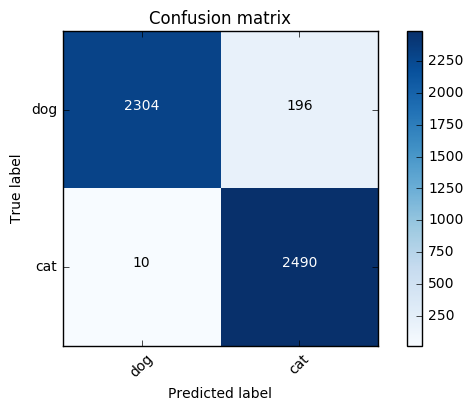

In [62]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Retraining more layers

Now that we've fine-tuned the new final layer, can we, and should we, fine-tune *all* the dense layers? The answer to both questions, it turns out, is: yes! Let's start with the "can we" question...

### An introduction to back-propagation

The key to training multiple layers of a model, rather than just one, lies in a technique called "back-propagation" (or *backprop* to its friends). Backprop is one of the many words in deep learning parlance that is creating a new word for something that already exists - in this case, backprop simply refers to calculating gradients using the *chain rule*. (But we will still introduce the deep learning terms during this course, since it's important to know them when reading about or discussing deep learning.)

As you (hopefully!) remember from high school, the chain rule is how you calculate the gradient of a "function of a function"--something of the form *f(u), where u=g(x)*. For instance, let's say your function is ```pow((2*x), 2)```. Then u is ```2*x```, and f(u) is ```power(u, 2)```. The chain rule tells us that the derivative of this is simply the product of the derivatives of f() and g(). Using *f'(x)* to refer to the derivative, we can say that: ```f'(x) = f'(u) * g'(x) = 2*u * 2 = 2*(2*x) * 2 = 8*x```.

Let's check our calculation:

In [63]:
# sympy let's us do symbolic differentiation (and much more!) in python
import sympy as sp
# we have to define our variables
x = sp.var('x')
# then we can request the derivative or any expression of that variable
pow(2 * x, 2).diff()

8*x

The key insight is that the stacking of linear functions and non-linear activations we learnt about in the last section is simply defining a function of functions (of functions, of functions...). Each layer is taking the output of the previous layer's function, and using it as input into its function. Therefore, we can calculate the derivative at any layer by simply multiplying the gradients of that layer and all of its following layers together! This use of the chain rule to allow us to rapidly calculate the derivatives of our model at any layer is referred to as *back propagation*.

The good news is that you'll never have to worry about the details of this yourself, since libraries like Theano and Tensorflow (and therefore wrappers like Keras) provide *automatic differentiation* (or *AD*). ***TODO***

### Training multiple layers in Keras

The code below will work on any model that contains dense layers; it's not just for this VGG model.

NB: Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

In [64]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index, layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable = True

Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.

In [79]:
opt.lr = 0.01 # K.set_value(opt.lr, 0.01); model.optimizer.lr = 0.01
fit_model(model, batches, val_batches, 3)

Epoch 1/3
12800/12800 [==============================] - 449s - loss: 0.6386 - acc: 0.9599 - val_loss: 0.3343 - val_acc: 0.9788
Epoch 2/3
12800/12800 [==============================] - 448s - loss: 0.5251 - acc: 0.9667 - val_loss: 0.3366 - val_acc: 0.9784
Epoch 3/3
12800/12800 [==============================] - 449s - loss: 0.4827 - acc: 0.9694 - val_loss: 0.4814 - val_acc: 0.9700


This is an extraordinarily powerful 5 lines of code. We have fine-tuned all of our dense layers to be optimized for our specific data set. This kind of technique has only become accessible in the last year or two - and we can already do it in just 5 lines of python!

In [82]:
model.save_weights(model_path + 'finetune2.h5')

There's generally little room for improvement in training the convolutional layers, if you're using the model on natural images (as we are). However, there's no harm trying a few of the later conv layers, since it may give a slight improvement, and can't hurt (and we can always load the previous weights if the accuracy decreases).

In [84]:
for layer in layers[12:]: layer.trainable=True
opt.lr = 0.001

In [85]:
fit_model(model, batches, val_batches, 3)

Epoch 1/3
12800/12800 [==============================] - 448s - loss: 0.4641 - acc: 0.9709 - val_loss: 0.3796 - val_acc: 0.9764
Epoch 2/3
12800/12800 [==============================] - 448s - loss: 0.4496 - acc: 0.9716 - val_loss: 0.5697 - val_acc: 0.9640
Epoch 3/3
12800/12800 [==============================] - 449s - loss: 0.4450 - acc: 0.9720 - val_loss: 0.3321 - val_acc: 0.9794


In [ ]:
preds = model.predict_classes(val_data, batch_size=batch_size)
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

In [86]:
model.save_weights(model_path + 'finetune3.h5')

You can always load the weights later and use the model to do whatever you need:

In [90]:
model.load_weights(model_path + 'finetune2.h5')
model.evaluate_generator(get_batches(path + 'valid', gen, False, batch_size*2), val_batches.N)

Found 5000 images belonging to 2 classes.


[0.4813914234161395, 0.96999999999999997]

In [ ]:
np.clip # pseudo-regularization to reduce penalty of over-confidence of model, which
# occurs after many epochs

In [ ]:
vgg.fit(batches, val_batches, nb_epoch=1) # fit
vgg.model.save_weights(path + 'results/ft2.h5') # save
vgg.model.optimizer.lr = 0.01 # change lr
vgg.fit(batches, val_batches, nb_epoch=1) # fit
vgg.model.save_weights(path + 'results/ft2_1.h5') # save weights
vgg.fit(batches, val_batches, nb_epoch=1)

In [1]:
# https://www.kaggle.com/c/state-farm-distracted-driver-detection/data
# download data and then create validation from train
"""
import os
import random

path = 'data/distracted_driver/imgs/'

if not os.path.isdir(path + 'val'): # make validation folder
    os.mkdir(path + 'val')

for driver_class in os.listdir(path + 'train/'): # move 20% of train to validation
    images = os.listdir(path + 'train/' + driver_class)
    val_list = random.sample(images, len(images) // 5)
    
    if not os.path.isdir(path + 'val/' + driver_class):
        os.mkdir(path + 'val/' + driver_class)
    for image in val_list:
        os.rename(path + 'train/' + driver_class + '/' + image, path + 'val/' + driver_class + '/' + image)
""";


"""
import os

if not os.path.isdir(path + 'test/unlabeled'): # moving test set into a folder of its own
    os.rename(path + 'test/', path + 'unlabeled/')
    os.mkdir(path + 'test/')
    os.rename(path + 'unlabeled/', path + 'test/unlabeled/')
""";

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix
from utils import get_batches, plot_confusion_matrix
from keras.layers.core import Dense
from vgg16 import Vgg16

# np.set_printoptions(precision=4, linewidth=100)
# from utils import plots, get_batches, plot_confusion_matrix, get_data
# from sklearn.preprocessing import OneHotEncoder
# import os, json
# from glob import glob
# import utils; reload(utils)
# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.optimizers import SGD, RMSprop
# from keras.utils.data_utils import get_file
# from keras.layers import Input
# from keras.layers.core import Flatten, Dense, Dropout, Lambda
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

vgg = Vgg16() # weights already loaded

path = 'data/distracted_driver/imgs/'
model_path = 'data/distracted_driver/models/'
batch_size = 64
train_batches = vgg.get_batches(path + 'train/', batch_size=batch_size, shuffle=True)
val_batches = vgg.get_batches(path + 'val/', batch_size=batch_size * 2, shuffle=False)

vgg.finetune(train_batches) # optimizer is Adam

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [2]:
%%time
vgg.fit(train_batches, val_batches, nb_epoch=1)  # 2 minutes; 582 // 60, 582 % 60


#"""
# save weights
import os

if not os.path.isdir(model_path): # make validation folder
    os.mkdir(model_path)

vgg.model.save_weights(model_path + 'finetune1.h5') # distracted driver folder
#""";

Epoch 1/1
17943/17943 [==============================] - 540s - loss: 2.0048 - acc: 0.4430 - val_loss: 0.5370 - val_acc: 0.8460
CPU times: user 12min 34s, sys: 1min 58s, total: 14min 33s
Wall time: 9min 12s


In [3]:
%%time 
# getting test scores
vgg.model.load_weights(model_path + 'finetune1.h5')

"""
val_batch, val_scores = vgg.test(path + 'val/', batch_size=batch_size * 2)
""";

CPU times: user 68 ms, sys: 216 ms, total: 284 ms
Wall time: 281 ms


In [8]:
"""
import pandas as pd

test_batches = vgg.get_batches(path + 'test/', batch_size=batch_size * 2, shuffle=False)
df_filesnames = pd.DataFrame({'img': [name.split('/')[1] for name in test_batches.filenames]}) # have to give correct key name
""";

Found 79726 images belonging to 1 classes.


In [9]:
# separate conv from dense
from keras.models import Sequential

first_dense_idx = [index for index, layer in enumerate(vgg.model.layers) if type(layer) is Dense][0]
conv_layers = vgg.model.layers[:first_dense_idx]
conv_model = Sequential(conv_layers)

dense_layers = vgg.model.layers[first_dense_idx:]

import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [11]:
%%time
#"""
# this is possible since these features are much smaller than 
# raw images and are capable of being loaded into memory
trn_features = conv_model.predict_generator(train_batches, val_samples=train_batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_samples=val_batches.nb_sample)

save_array(model_path + 'train_conv_features.bc', trn_features)
save_array(model_path + 'val_conv_features.bc', val_features)
#""";

CPU times: user 12min 33s, sys: 1min 57s, total: 14min 30s
Wall time: 9min 3s


In [31]:
%%time
trn_features = load_array(model_path + 'train_conv_features.bc/')
val_features = load_array(model_path + 'val_conv_features.bc/')

print(trn_features.shape, val_features.shape)

((17943, 25088), (4481, 25088))
CPU times: user 5.07 s, sys: 844 ms, total: 5.91 s
Wall time: 2.23 s


In [35]:
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam

opt = Adam(lr=0.1) # manual tuning

# reflate weights from dropout; no dropout -> smaller weights
def proc_wgts(layer): return [o / 2 for o in layer.get_weights()]

def get_fc_model():
    model = Sequential([
            Dense(4096, activation='relu', input_dim=conv_layers[-1].output_shape[1]),
            Dropout(0.),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(10, activation='softmax') # modified to accomodate distracted driver dataset
            ])
            
    for l1, l2 in zip(model.layers, dense_layers):
            l1.set_weights(proc_wgts(l2))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
%%time
from sklearn.preprocessing import OneHotEncoder

def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

trn_labels = onehot(train_batches.classes)
val_labels = onehot(val_batches.classes)

fc_model = get_fc_model()

CPU times: user 2.07 s, sys: 652 ms, total: 2.72 s
Wall time: 2.72 s


In [34]:
%%time
fc_model.fit(trn_features, trn_labels)

Epoch 1/10
 3392/17943 [====>.........................] - ETA: 42s - loss: 14.2207 - acc: 0.1106

KeyboardInterrupt: 

In [37]:
%%time 
fc_model.evaluate(val_features, y=val_labels)

4480/4481 [============================>.] - ETA: 0sCPU times: user 1.98 s, sys: 364 ms, total: 2.34 s
Wall time: 2.25 s


[2.513652315046127, 0.0075875920553447893]

In [ ]:
%%time
### predict_generator is faster than manual because it has queue for loading images, though sometimes gives memory error
test_batches = vgg.get_batches(path + 'test/', batch_size=batch_size * 2, shuffle=False)
temp = vgg.model.predict_generator(test_batches, test_batches.N)

Found 79726 images belonging to 1 classes.


In [ ]:
"""
%%time
# 6:52
from tqdm import tqdm
import psutil; import os

test_batches = vgg.get_batches(path + 'test/', batch_size=batch_size * 2, shuffle=False)

images = []
for i in tqdm(range(int(np.ceil(test_batches.N / float(test_batches.batch_size))))):
    minibatch = next(test_batches)[0]
    images.append(vgg.model.predict_on_batch(minibatch))
#    print(psutil.Process(os.getpid()).memory_info().rss / 1e9)

temp = np.concatenate(images)
""";

In [82]:
from IPython.display import FileLink

predictions = pd.DataFrame(temp, columns=vgg.classes)
#pd.read_csv('temp.csv', names=sorted(val_batches.class_indices, key=val_batches.class_indices.get))
pd.concat([df_filesnames, predictions], axis=1).to_csv(path + 'submission_2.csv', index=False)

FileLink(path + 'submission_2.csv')

/home/ubuntu/courses/deeplearning1/nbs/data/distracted_driver/imgs/submission_2.csv

In [ ]:
test_batch, test_scores = vgg.test(path + 'test/', batch_size=batch_size * 2)

In [90]:
%time val_batch, val_scores = vgg.test(path + 'val/', batch_size=batch_size * 2)

Found 4481 images belonging to 10 classes.
CPU times: user 2min 48s, sys: 24.9 s, total: 3min 13s
Wall time: 1min 50s


In [110]:
val_labels = onehot(val_batches.classes)

In [137]:
%%time
#vgg.model.evaluate(val_data, val_labels)

#vgg.model.evaluate_generator(get_batches(path + 'valid', gen, False, batch_size*2), val_batches.N)
vgg.model.evaluate_generator(val_batches, val_batches.N)
#vgg.model.evaluate(val_batch, val_labels)

CPU times: user 2min 38s, sys: 24.7 s, total: 3min 3s
Wall time: 1min 50s


[3.2667276776813283, 0.090381611247489405]

In [139]:
%%time
#vgg.model.evaluate(val_data, val_labels)

#vgg.model.evaluate_generator(get_batches(path + 'valid', gen, False, batch_size*2), val_batches.N)
vgg.model.evaluate_generator(val_batches, val_batches.N)
#vgg.model.evaluate(val_batch, val_labels)

CPU times: user 2min 38s, sys: 24.7 s, total: 3min 3s
Wall time: 1min 50s


[0.58757410756162876, 0.81856728408837309]

In [131]:
from sklearn.metrics import log_loss
import numpy as np

print(log_loss(val_labels, val_scores))
print(log_loss(val_labels, np.clip(val_scores, 0.025, 0.975)))
print(log_loss(val_labels, np.clip(val_scores, 0.05, 0.95)))

3.26672767305
2.88110645346
2.65701011186


In [14]:
for layer in vgg.model.layers:
    if type(layer) is Dense:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
for layer in vgg.model.layers:
    print type(layer), layer.trainable

<class 'keras.layers.core.Lambda'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.pooling.MaxPooling2D'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.pooling.MaxPooling2D'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.convolutional.ZeroPadding2D'> False
<class 'keras.layers.convolutional.Convolution2D'> False
<class 'keras.layers.pooling.MaxPooling2D'> False
<class 'ker

In [16]:
train_data = get_data('distracted_driver/imgs/train/in/')

OSError: [Errno 2] No such file or directory: 'distracted_driver/imgs/train/in/'

In [ ]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path + 'valid', shuffle=False, batch_size=1)
batches = get_batches(path + 'train', shuffle=False, batch_size=1)

In [ ]:
# np.clip; keras.metrics.categorical_crossentropy(val_labels, do_clip(val_preds, 0.93)).eval()
# save data, weights
# plot confusion
# check most right, wrong, ambivalent
# write about test, predict, fit, generator variants, and inputs

In [29]:
%%capture output

print('hello panda')
print(5 + 3)

In [30]:
output.show()

hello
